In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from torch_geometric.utils import subgraph
from torch_geometric.data import Data

from config import *
from data_preprocess import *
from utils import plot_curves, visualize_embeddings
from model import init_model
from train import run_federated_training
from rdp_accounting import compute_rdp_epsilon, plot_epsilon_growth
from utils import visualize_embeddings


In [ ]:
df = load_nsl_kdd("nslkdd_data/KDDTrain+.txt", "nslkdd_data/KDDTest+.txt")
X, y = preprocess_data(df)
X_train, X_val, X_test, y_train, y_val, y_test = split_data(X, y)


In [ ]:
# Build PyG datasets
train_data = build_pyg_data(X_train, y_train)
val_data   = build_pyg_data(X_val, y_val)
test_data  = build_pyg_data(X_test, y_test)

In [ ]:
# Split into clients
num_clients = 3
all_idx = np.random.permutation(train_data.num_nodes)
client_indices = np.array_split(all_idx, num_clients)

clients_data = []
for idx in client_indices:
    idx = torch.tensor(idx, dtype=torch.long)
    sub_edge_index, _ = subgraph(idx, train_data.edge_index, relabel_nodes=True)
    x_sub, y_sub = train_data.x[idx], train_data.y[idx]
    clients_data.append(Data(x=x_sub, edge_index=sub_edge_index, y=y_sub))

    print(f"Client: {len(idx)} nodes, {sub_edge_index.size(1)} edges")

Client: 34654 nodes, 80974 edges
Client: 34654 nodes, 80854 edges
Client: 34653 nodes, 80591 edges


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
global_model = init_model(train_data.num_features, device)

In [ ]:
trained_model, train_losses, val_losses, val_accs = run_federated_training(
    global_model=global_model,
    clients_data=clients_data,
    val_data=val_data,
    rounds=ROUNDS,
    local_epochs=LOCAL_EPOCHS,
    lr=LR,
    use_dp=USE_DP,
    clip_norm=CLIP_NORM,
    noise_multiplier=NOISE_MULTIPLIER,
    device=device
)


🚀 Starting Privacy-Preserving Federated Training...

Round 1 | Client 1: loss=0.4800, acc=0.7682
Round 1 | Client 2: loss=0.4702, acc=0.7675
Round 1 | Client 3: loss=0.4750, acc=0.7715
✅ Round 1: avg_train_loss=0.4751, val_loss=1.6322, val_acc=0.7157

Round 2 | Client 1: loss=1.3182, acc=0.7799
Round 2 | Client 2: loss=1.2401, acc=0.7795
Round 2 | Client 3: loss=1.3012, acc=0.7788
✅ Round 2: avg_train_loss=1.2865, val_loss=4.3810, val_acc=0.5851

Round 3 | Client 1: loss=3.2883, acc=0.6307
Round 3 | Client 2: loss=3.2578, acc=0.6318
Round 3 | Client 3: loss=3.2702, acc=0.6310
✅ Round 3: avg_train_loss=3.2721, val_loss=2.8992, val_acc=0.7467

Round 4 | Client 1: loss=2.6363, acc=0.7818
Round 4 | Client 2: loss=2.5914, acc=0.7817
Round 4 | Client 3: loss=2.6552, acc=0.7821
✅ Round 4: avg_train_loss=2.6276, val_loss=3.1496, val_acc=0.8260

Round 5 | Client 1: loss=2.7609, acc=0.8362
Round 5 | Client 2: loss=2.5539, acc=0.8392
Round 5 | Client 3: loss=2.6351, acc=0.8417
✅ Round 5: avg_tra

In [ ]:
# Privacy accounting + plot
epsilons = compute_rdp_epsilon(NOISE_MULTIPLIER, NUM_CLIENTS, ROUNDS, DELTA)
print(f"Formal RDP Accounting: ε ≈ {epsilons[-1]:.2f}, δ={DELTA}")

🔐 Formal RDP Accounting: ε ≈ 21.53, δ = 1e-5


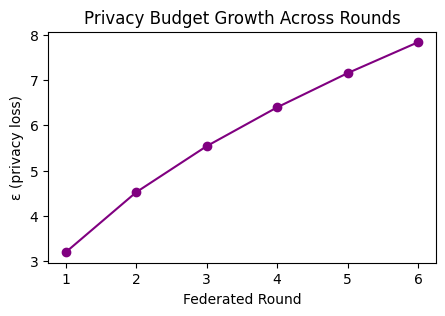

In [ ]:
plot_epsilon_growth(epsilons, DELTA)

In [ ]:
global_model.eval()
with torch.no_grad():
    out = global_model(test_data.x.to(device), test_data.edge_index.to(device))
    preds = out.argmax(1).cpu().numpy()
    labels = test_data.y.cpu().numpy()

acc = accuracy_score(labels, preds)
prec = precision_score(labels, preds)
rec = recall_score(labels, preds)
f1 = f1_score(labels, preds)
auc = roc_auc_score(labels, out.softmax(1)[:,1].cpu().numpy())

print("\n==== FINAL TEST METRICS ====")
print(f"Accuracy: {acc:.4f} | Precision: {prec:.4f} | Recall: {rec:.4f} | F1: {f1:.4f} | AUC: {auc:.4f}")


==== FINAL TEST METRICS ====
Accuracy: 0.8795 | Precision: 0.8898 | Recall: 0.8552 | F1: 0.8722 | AUC: 0.9139


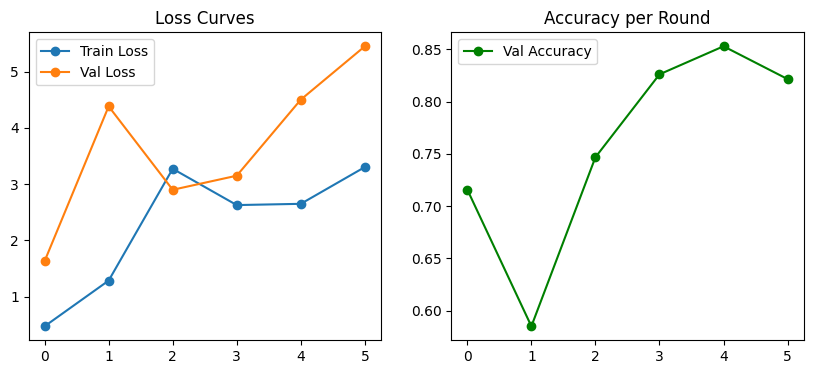

In [ ]:
plot_curves(train_losses, val_losses, val_accs)


Running t-SNE...


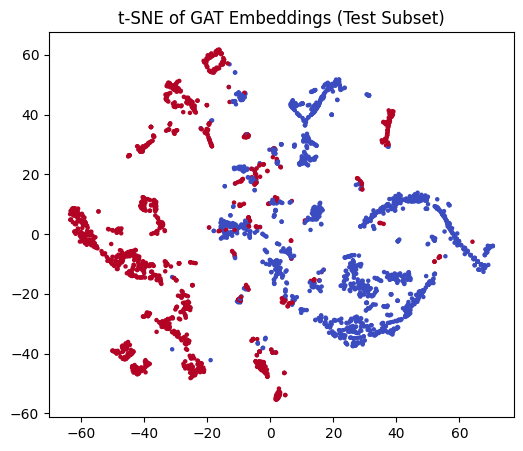

✅ Model saved to global_gat_privfed_nslkdd.pt


In [ ]:
print("\nRunning t-SNE...")
labels = test_data.y.cpu().numpy() if hasattr(test_data.y, "cpu") else test_data.y
visualize_embeddings(
    model=global_model,
    data=test_data,
    labels=labels,
    max_samples=3000  # you can reduce if it’s too slow
)

torch.save(global_model.state_dict(), "global_gat_privfed_nslkdd.pt")
print("✅ Model saved to global_gat_privfed_nslkdd.pt")